In [2]:
import geopandas as gpd

import matplotlib.pyplot as plt

import networkx as nx

import osmnx as ox

import contextily as ctx

In [3]:
ATL = gpd.read_file('data/MARTA_BRT_routes_stops.geojson')

In [4]:
ATL = ATL.mask(ATL.eq('None')).dropna()
ATL['lon'] = ATL['geometry'].x
ATL['lat'] = ATL['geometry'].y
test = ATL.loc[ATL['Route'] == 'Capitol Ave BRT']

In [5]:
#set variables at the top so they can be easily changed as needed
network_type = 'walk'
trip_times = [5,10,15]
meters_per_minute = 75
###I think the place variable needs to be inside the for loop(?)
#define the function
def isomap(gdf):
    G = ox.graph.graph_from_point(place, dist=1000, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, clean_periphery=True, custom_filter=None)
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    
    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx-minx)/2 + minx
    centroid_y = (maxy-miny)/2 + miny
    center_node = ox.get_nearest_node(G, 
                                  (centroid_y,centroid_x), 
                                  method = 'euclidean')
    gdf_edges['walk_time'] = gdf_edges['length']/meters_per_minute

    iso_colors = ox.plot.get_colors(n=len(trip_times), 
                                    cmap='viridis', 
                                    start=0, 
                                    return_hex=True)

    trip_times.sort(reverse=True)
    time_color = list(zip(trip_times, iso_colors))
    time_color
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
    #gdf_edges.plot(figsize=(10,10))
    
    for time, color in list(time_color):
        subgraph = nx.ego_graph(G, center_node, radius=time, distance='time')  
        for node in subgraph.nodes():
            gdf_nodes.loc[node,'time'] = str(time) + ' mins'
            gdf_nodes.loc[node,'color'] = color
    gdf_nodes['color'].fillna('#cccccc', inplace=True)
    isochrones = gdf_nodes.dissolve('time')
    isochrones = isochrones.convex_hull.reset_index()
    isochrones.columns=['time','geometry']
    #isochrones.plot(alpha=.2)
    
    
    
    fig, ax = plt.subplots(figsize=(10,10))

# add the edges to ax
    gdf_edges.plot(ax=ax,
                   linewidth=0.5,
                   alpha = .2,
                   edgecolor='gainsboro', 
                   zorder=10)

# add all nodes to ax
    #gdf_nodes.plot(ax=ax, 
                   #markersize=1, 
                   #zorder=10)

# add the center node in red
    gdf_nodes.loc[[center_node]].plot(ax=ax,
                                      color='r', 
                                      zorder=30)
# add isochrones
    isochrones.plot(alpha=.4,
                   ax=ax,
                   column='time',
                   cmap='viridis',
                   legend=True,
                   zorder=20)

# no axis
    ax.axis('off')

# title
    ax.set_title('Walking accessibility to BRT stop ' + row['Stop']) ###this also needs to iterate w/the process

# add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
    


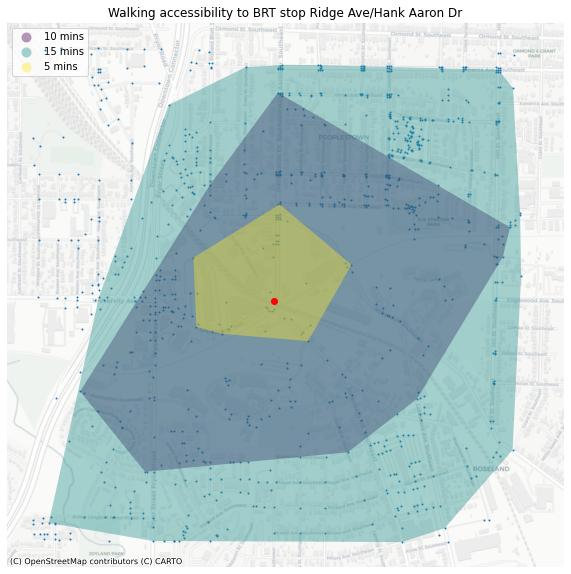

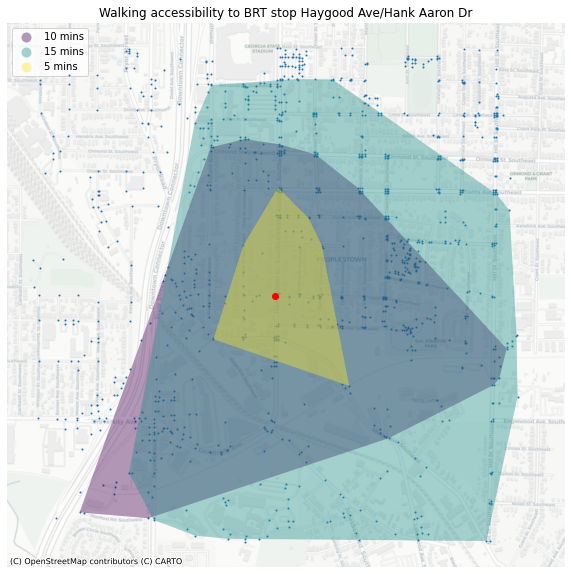

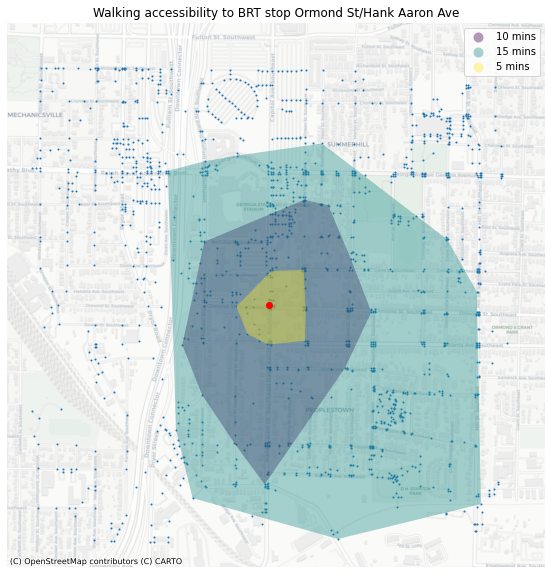

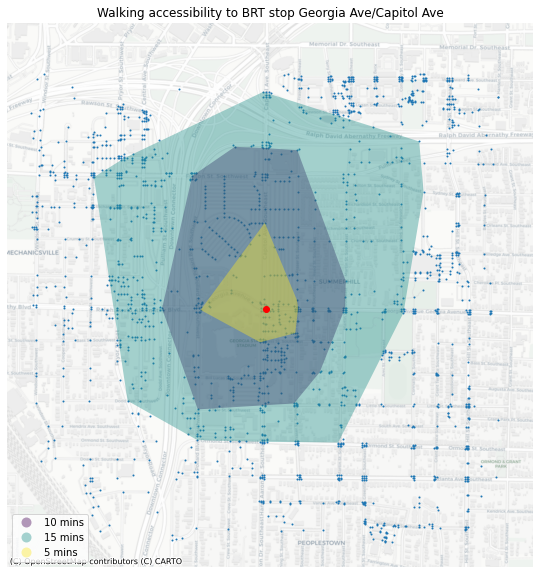

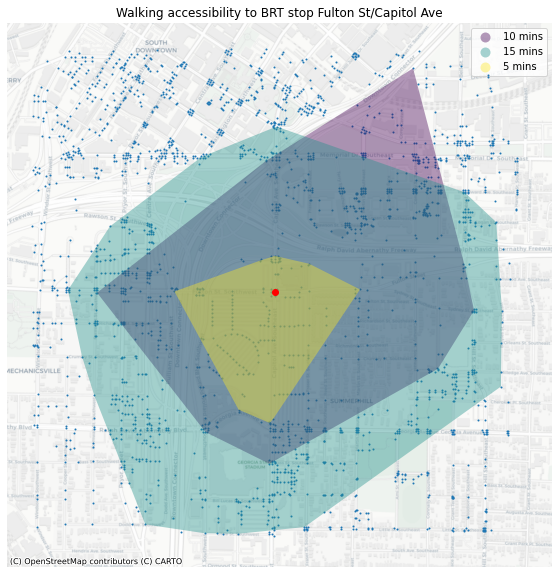

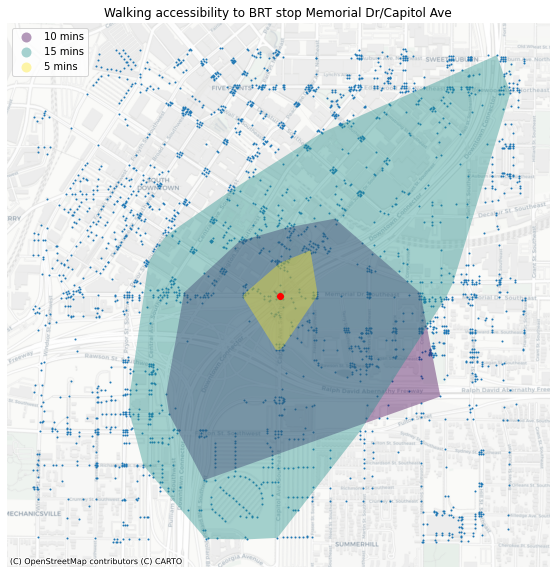

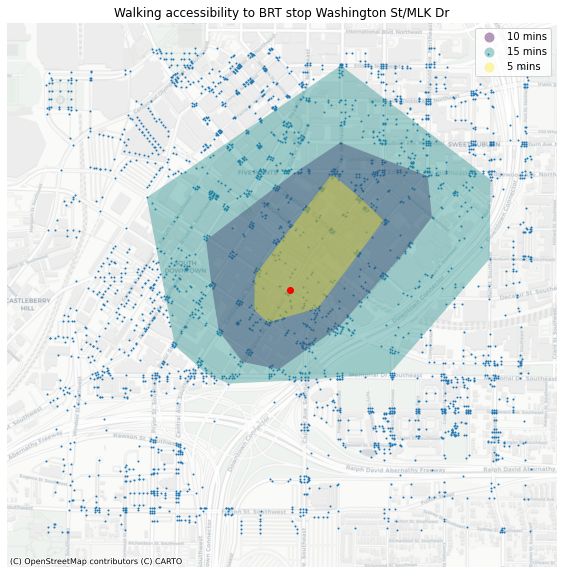

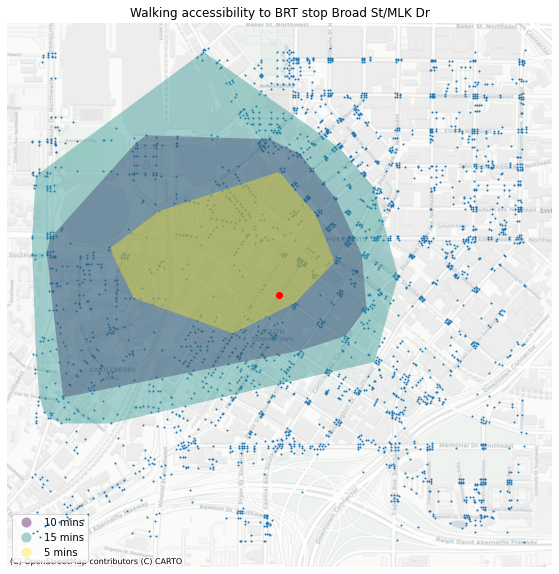

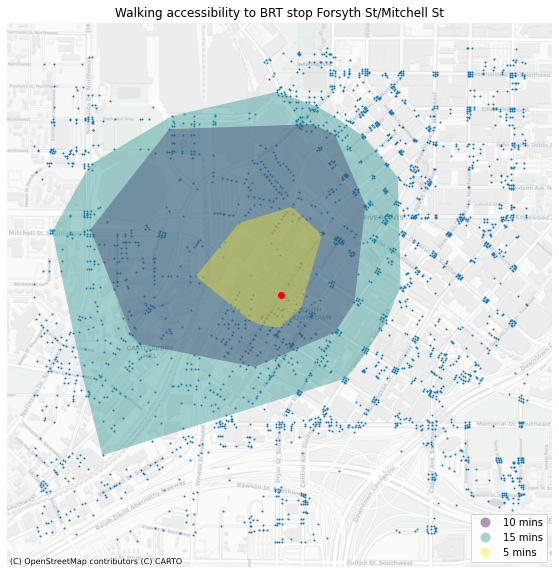

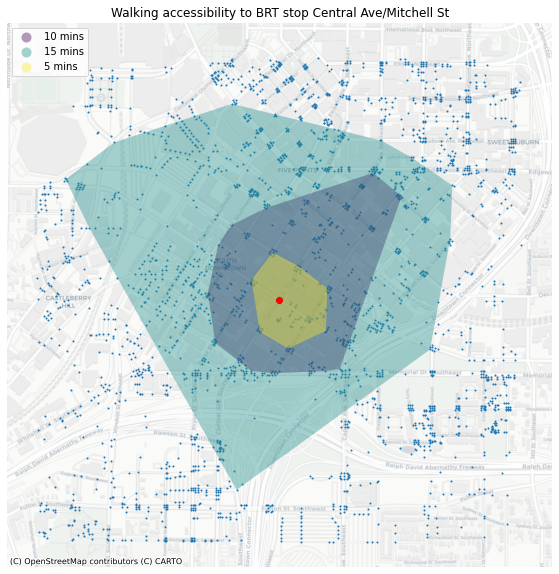

In [6]:
#run the function for all values in the list
for index,row in test.iterrows():
    place = row[7], row[6] #gotta make sure this cycles through
    isomap(test)
#win!